# One way ANOVA
Однофакторный дисперсионный анализ

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

4 типа терапии: A,B,C,D  
для каждого значения уровень экспрессии гена

In [2]:
data = pd.read_csv('genetherapy.csv')

In [3]:
data.head()

,expr,Therapy
0,100,A
1,96,A
2,101,A
3,95,A
4,103,A


In [4]:
data.groupby('Therapy').agg({'count', 'mean', np.std})

expr                
              mean count       std
Therapy                           
A        99.733333    15  4.165619
B        98.800000    15  5.894307
C        94.400000    15  5.193402
D        92.333333    15  3.735289

По 15 наблюдений в каждой из 4х групп  

H0: mean1 = mean2 = mean3 = mean4  
H1: meani != mean

In [5]:
samples=[list(frame) for group,frame in data.groupby('Therapy')['expr']]
samples # список значений для каждой группы

[[100, 96, 101, 95, 103, 99, 97, 96, 98, 106, 106, 104, 95, 95, 105],
 [100, 100, 95, 84, 101, 101, 95, 106, 105, 97, 103, 94, 94, 100, 107],
 [91, 96, 94, 96, 91, 85, 98, 93, 100, 85, 101, 101, 90, 98, 97],
 [92, 85, 95, 89, 91, 91, 99, 94, 97, 94, 87, 93, 96, 92, 90]]

In [6]:
stats.f_oneway(*samples)

F_onewayResult(statistic=8.03730248114399, pvalue=0.00015249722895229536)

Вероятность получить F=8.03 и более (при односторонннем правом критерии) = 0.0001 < 0.05 => **H0 отклоняем**  
Есть хотя бы одно среднее значимо отличное от других

In [7]:
# Внутригрупповая сумма квадратов (различия данных в каждой группе)
def ssw(main_data: pd.DataFrame, group_col: str, value_col: str):
    group_names = data[group_col].unique()
    # (значение в группе - общее среднее) в квадрате
    return np.sum([
        (
            main_data.loc[main_data[group_col] == group, value_col] -
            main_data.loc[main_data[group_col] == group, value_col].mean()
        ) ** 2
        for group in group_names
    ])

# междугрупповая сумма квадратов
def ssb(main_data: pd.DataFrame, group_col: str, value_col: str):
    group_names = data[group_col].unique()
    overall_mean = main_data[value_col].mean()
    # число наблюдений в группе * (среднее группы - общее среднее) в квадрате
    return np.sum([
        len(main_data.loc[main_data[group_col] == group, value_col]) * (
            main_data.loc[main_data[group_col] == group, value_col].mean() -
            overall_mean
        ) ** 2
        for group in group_names
    ])

In [8]:
N = len(data) # число наблюдений
m = data['Therapy'].nunique() # число групп

# степени свободы
ssb_df = m - 1
ssw_df = N - m

In [9]:
SSW = ssw(data, 'Therapy', 'expr')
SSB = ssb(data, 'Therapy', 'expr')

f_val, p_val = stats.f_oneway(*samples)

anova_results = pd.DataFrame([
{
        'Df': ssb_df,
        'Sum Sq': '{0:.2f}'.format(SSB),
        'Mean Sq': '{0:.2f}'.format(SSB / ssb_df),
        'F-value': '{0:.2f}'.format(f_val),
        'p-value': '{0:.4f}'.format(p_val),
    },
    {
        'Df': ssw_df,
        'Sum Sq': '{0:.2f}'.format(SSW),
        'Mean Sq': '{0:.2f}'.format(SSW / ssw_df),
        'F-value': '',
        'p-value': '',
    },
], index=['Therapy', 'Residuals'])

print(anova_results)
# Residuals - внутригрупповая изменчивость

           Df   Sum Sq Mean Sq F-value p-value
Therapy     3   560.72  186.91    8.04  0.0002
Residuals  56  1302.27   23.25                


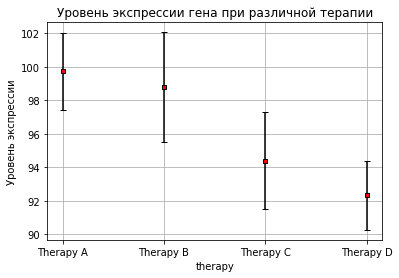

In [10]:
# ДИ
#выставляем уровень значимости
p = 0.95

data_agg = data.groupby(['Therapy']).agg(['count','mean','std'])
#для каждой выборки высчитываем интервал по формуле для t-распределения: (K * se), где 
#K t-value, зависит от степеней свободы df = n-1 и целевого значения вероятности p, 
#se - стандартная ошибка среднего = std/sqrt(n), std - стандартное отклонение выборки, n - количество элементов 
data_agg['interval'] = stats.t.ppf((1 + p)/2, data_agg['expr']['count']-1)*data_agg['expr']['std']/(data_agg['expr']['count'] ** 0.5)

#cтроим доверительные интервалы на графике
plt.errorbar(x='Therapy ' + data_agg.index, y=data_agg['expr']['mean'], yerr=data_agg['interval'], color="black", capsize=3, marker="s", markersize=4, mfc="red", mec="black", fmt ='o')
plt.title('Уровень экспрессии гена при различной терапии')
plt.grid()
plt.xlabel('therapy')
plt.ylabel('Уровень экспрессии')
plt.show()

Группы A,B вообще не пересекаются с группой D  
Средние не попадают в ДИ друг друга  
H0 о равенстве средних групп отклоняем

# сравнение каждой группы с поправкой критерий Тьюки (Tukey HSD)

In [11]:
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)

In [12]:
# попарное сравнение каждой группы с каждой
# se оштбка считается иначе
MultiComp = MultiComparison(data['expr'], data['Therapy'])

print(MultiComp.tukeyhsd().summary())
# разница, p-знач, нижняя грань, верхняя грань

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     A      B  -0.9333    0.9  -5.5961  3.7294  False
     A      C  -5.3333 0.0189  -9.9961 -0.6706   True
     A      D     -7.4  0.001 -12.0628 -2.7372   True
     B      C     -4.4 0.0712  -9.0628  0.2628  False
     B      D  -6.4667 0.0029 -11.1294 -1.8039   True
     C      D  -2.0667 0.6296  -6.7294  2.5961  False
-----------------------------------------------------


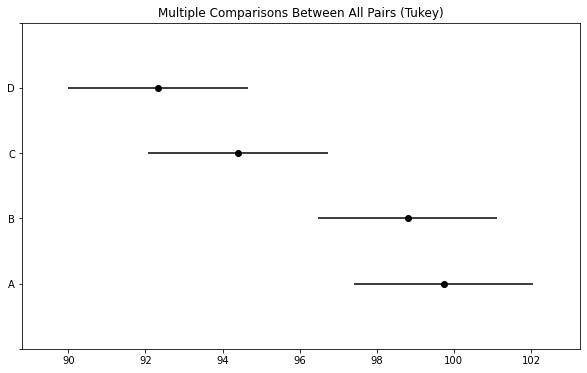

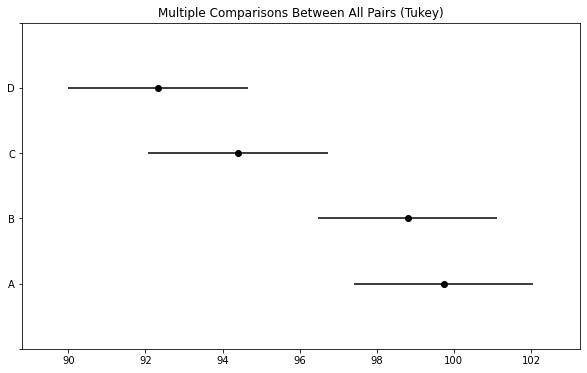

In [13]:
MultiComp.tukeyhsd().plot_simultaneous()

Если p < 0.05 или 0 не включен в ДИ, то H0 отклоняем и группы значимо различаются между собой  
Отличающиеся группы: AC, AD, BD